In [ ]:
'''
Four kinds of attention mechanisms
1. Simplified attention (Simplified attention technique)
2. Self attention (Self attention with trainable weights)
3. Causal attention (Attention method that allows LLM to use only past and current inputs)
4. Multi-head attention (Extension of self attention and causal attention that enables the model to simultaneously attend to information from different representation subspaces)

While we don’t need to know the inner workings of these encoder-decoder RNNs,
the key idea here is that the encoder part processes the entire input text into a hidden state (memory cell).
The decoder then takes in this hidden state to produce the output.
You can think of this hidden state as an embedding vector, a concept we discussed in chapter 2.

The big limitation of encoder-decoder RNNs is that the RNN can’t directly access earlier hidden states from the encoder during the decoding phase.
Consequently, it relies solely on the current hidden state, which encapsulates all relevant information.
This can lead to a loss of context, especially in complex sentences where dependencies might span long distances.

'''

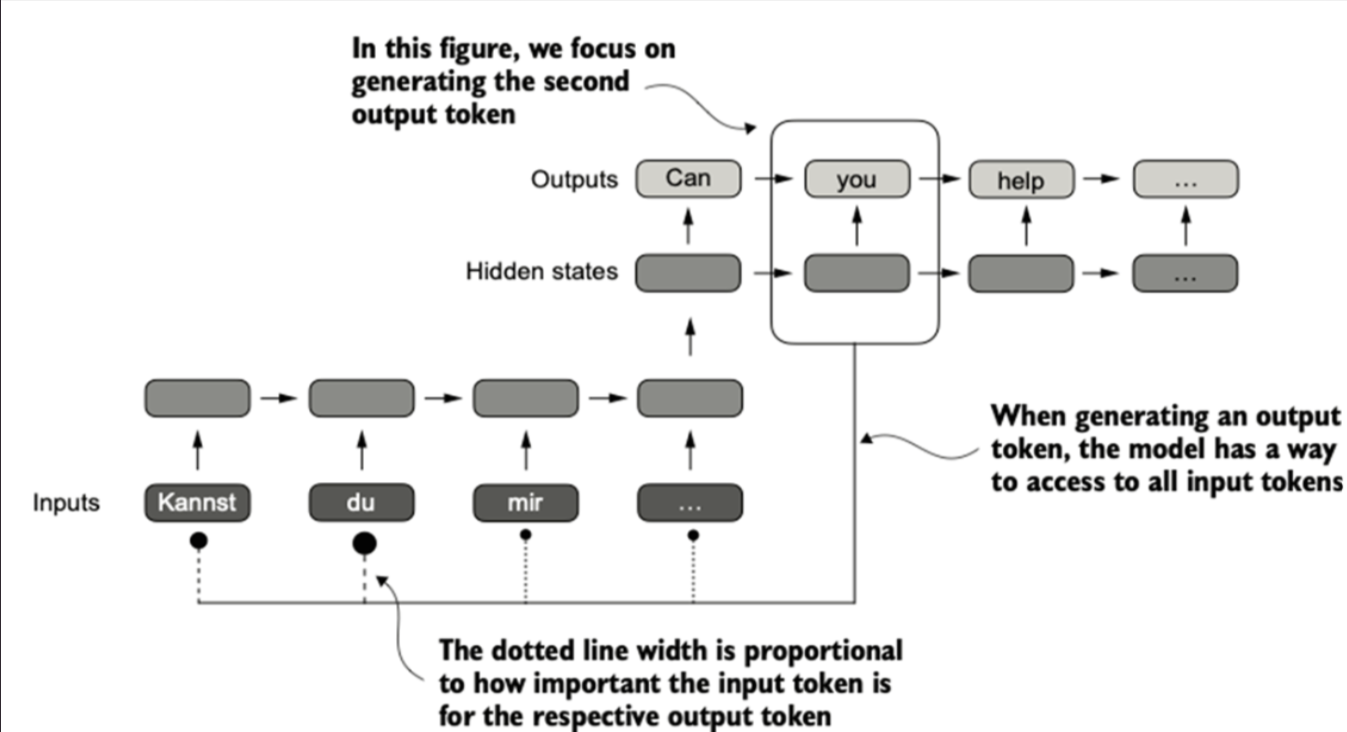

In [ ]:
'''
The above picture is of the Bahadanu attention mechanism where the decoder RNN has access to input weights along with attention weights which indicate how important
each input token is
'''

In [ ]:
'''
Self-attention is a mechanism that allows each position in the input sequence to attend to all positions in the same sequence when computing the representation of a sequence.
Self-attention is a key component of contemporary LLMs based on the transformer architecture, such as the GPT series.
'''

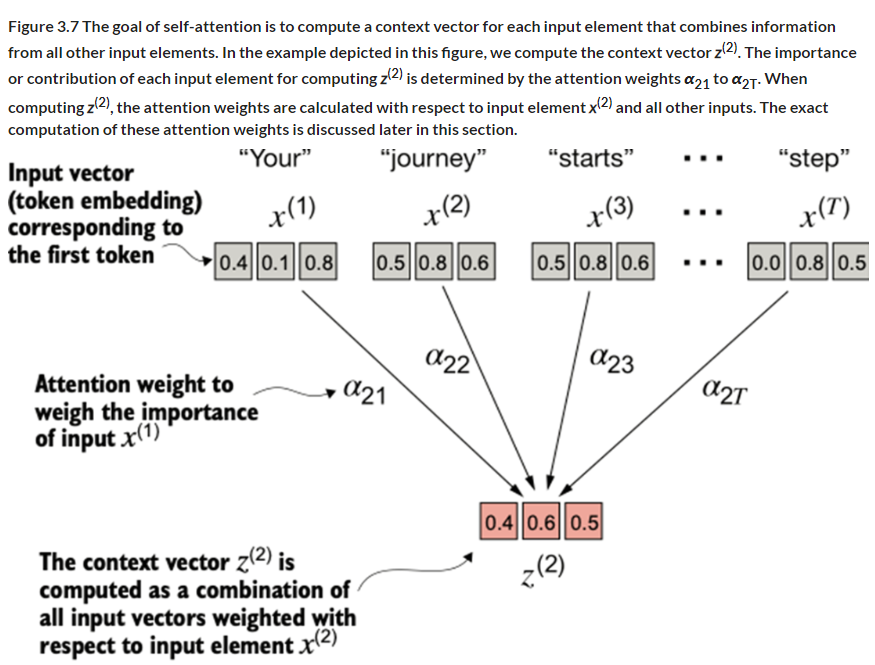

In [ ]:
'''
The context vector for xi stores info about the element itself wrt all the input tokens in the sequence.

In self-attention, context vectors play a crucial role.
Their purpose is to create enriched representations of each element in an input sequence (like a sentence) by incorporating information from all other elements in the sequence,
as illustrated in figure 3.7. This is essential in LLMs, which need to understand the relationship and relevance of words in a sentence to each other.
Later, we will add trainable weights that help an LLM learn to construct these context vectors so that they are relevant for the LLM to generate the next token.
In this section, we implement a simplified self-attention mechanism to compute these weights and the resulting context vector one step at a time.

'''

In [2]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [ ]:
'''
The first step of implementing self-attention is to compute the intermediate values ω, referred to as attention scores, as illustrated in figure 3.8.
(Please note that figure 3.8 displays the values of the preceding inputs tensor in a truncated version; for example, 0.87 is truncated to 0.8 due to spatial constraints.
In this truncated version, the embeddings of the words “journey” and “starts” may appear similar by random chance.)
'''

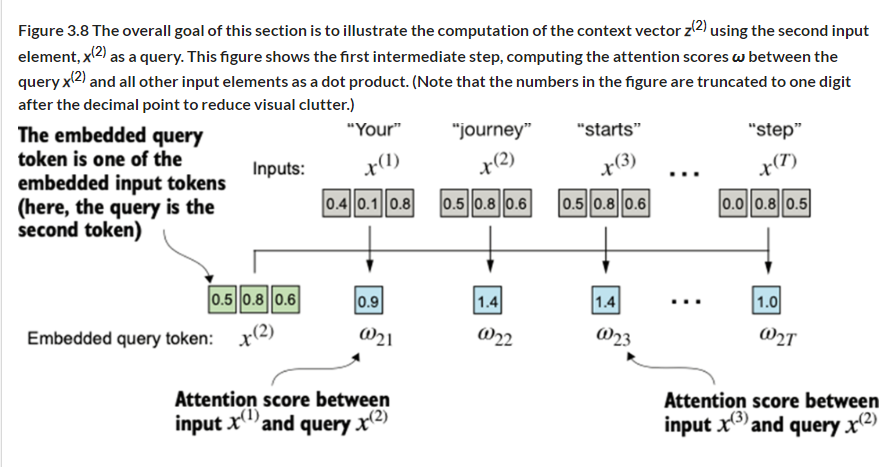

In [3]:
query = inputs[1]
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)
print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [4]:
'''
Now we normalize these attention scores we computed by taking a dot product.
'''

#Normalization 1

attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

'''
In practice, it’s more common and advisable to use the softmax function for normalization.
This approach is better at managing extreme values and offers more favorable gradient properties during training.
The following is a basic implementation of the softmax function for normalizing the attention scores:
'''

#Normalization 2

def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

#Normalization 3 using Pytorch

#Pytorch softmax to take care of overflow issues.

attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [ ]:
'''
Now that we have computed the normalized attention weights, we are ready for the final step illustrated in figure 3.10:
calculating the context vector z(2) by multiplying the embedded input tokens, x(i), with the corresponding attention weights and then summing the resulting vectors.
'''

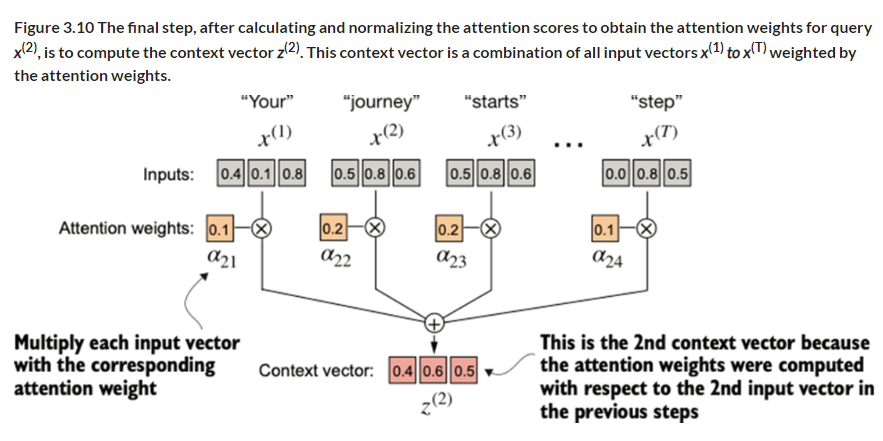

In [5]:
query = inputs[1] # 2nd input token is the query
context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    #print(context_vec_2)
    context_vec_2 += attn_weights_2[i]*x_i
    #print(x_i)
    #print(attn_weights_2[i])
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


In [6]:
'''
The complete Algorithm:
  1. Compute Attention scores - compute attention scores as dot product between input embedding vectors
  2. Compute Attention weights - Normalize the attention scores using softmax
  3. Compute Context vectors - Multiply respective weights to the embedding vectors and take their combined sum to construct Context vector

'''
#Method 1 using for loops
attn_scores = torch.empty(6, 6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
print(attn_scores)

#Method 2 using matrix multiplication - faster
attn_scores = inputs @ inputs.T
print(attn_scores)


tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [7]:
#Normalizing the attention scores using softmax
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [8]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


## Simple Self attention concluded

# Implementing self attention with trainable weights

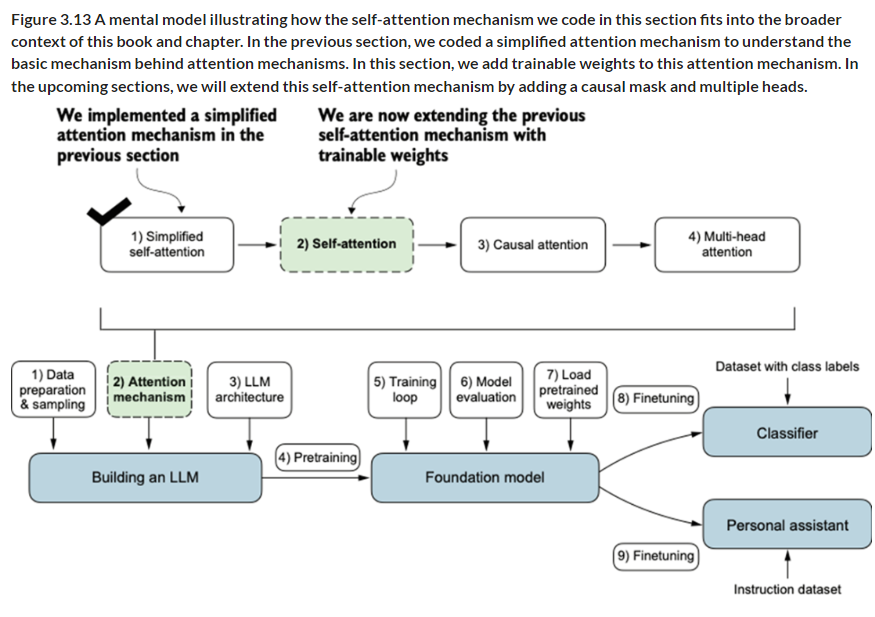

In [ ]:
'''
We will implement the self-attention mechanism step by step by introducing the three trainable weight matrices Wq, Wk, and Wv.
These three matrices are used to project the embedded input tokens, x(i), into query, key, and value vectors, as illustrated in figure 3.14.
'''

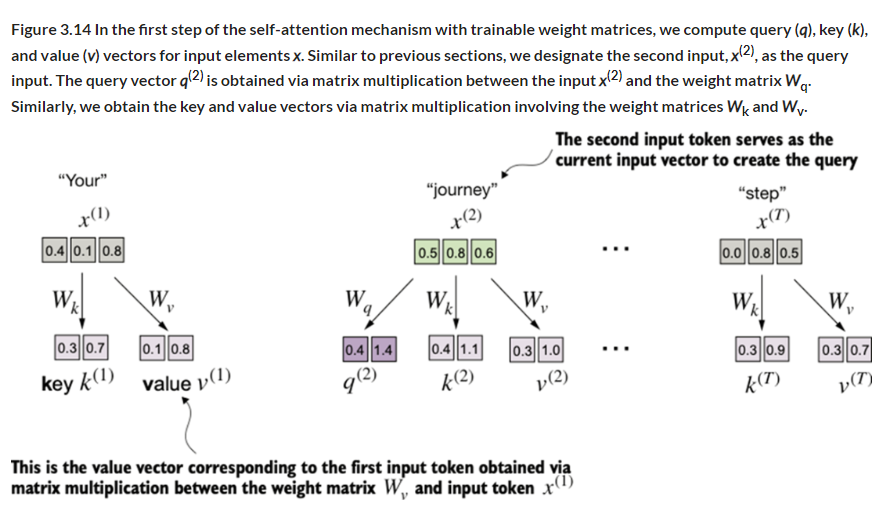

In [9]:
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2

'''
Note that in GPT-like models, the input and output dimensions are usually the same, but for illustration purposes,
to better follow the computation, we choose different input (d_in=3) and output (d_out=2) dimensions here.
'''

'\nNote that in GPT-like models, the input and output dimensions are usually the same, but for illustration purposes, \nto better follow the computation, we choose different input (d_in=3) and output (d_out=2) dimensions here.\n'

In [10]:
# Creating Wq, Wk, Wv matrices
torch.manual_seed(123)

#We set the requires_grad = False to reduce clutter but have to set it True at the time of model training
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

### torch.nn.Parameter():

```
   1.Function: torch.nn.Parameter()
   2.Description: This function wraps a tensor and marks it as a parameter, which means it is a tensor that you want to optimize (i.e., learn) during training.
   3.Parameters are special types of tensors that are automatically added to the list of parameters of a torch.nn.Module when assigned as attributes.
   4.Parameter: The tensor generated by torch.rand(d_in, d_out) in this case.
   5.Purpose: Wrapping a tensor with torch.nn.Parameter() allows it to be considered a model parameter, making it available for optimization.
```



In [11]:
query_2 = x_2 @ W_query #Computing query vector for x_2
key_2 = x_2 @ W_key #Computing key vector for x_2
value_2 = x_2 @ W_value #Computing value vector for x_2
print(query_2)

tensor([0.4306, 1.4551])


In [ ]:
'''
Note that in the weight matrices W, the term “weight” is short for “weight parameters,” the values of a neural network that are optimized during training.
This is not to be confused with the attention weights. As we already saw in the previous section,
attention weights determine the extent to which a context vector depends on the different parts of the input—i.e.,
to what extent the network focuses on different parts of the input.
In summary, weight parameters are the fundamental, learned coefficients that define the network’s connections, while attention weights are dynamic, context-specific values.
'''

In [12]:
keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


In [ ]:
#The second step is to compute attention scores

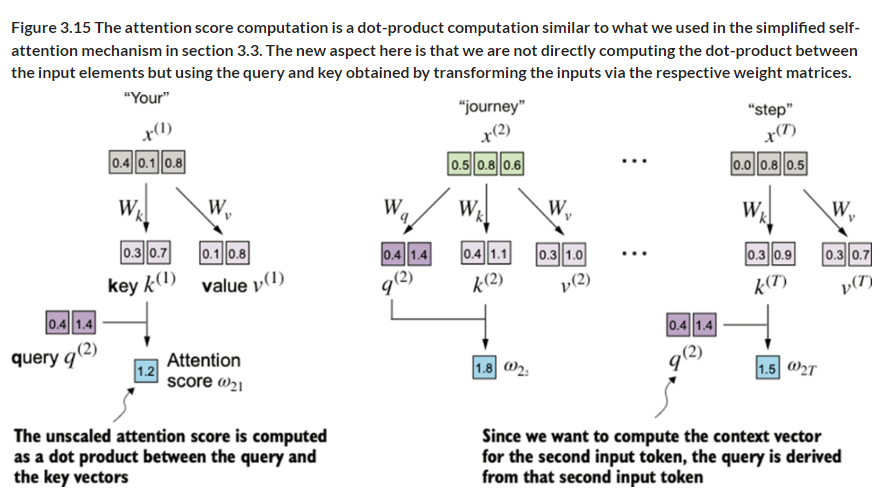

In [13]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


In [14]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2/d_k**0.5, dim = -1) # we also divide the attn_scores by the square root of embedding dimension size to reduce the attn_score and inc gradient step
print(attn_weights_2)

#The scaling by the square root of the embedding dimension is the reason why this self-attention mechanism is also called scaled-dot product attention.

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


In [15]:
context_vecs_2 = attn_weights_2 @ values
print(context_vecs_2)

tensor([0.3061, 0.8210])


In [ ]:
'''
Why query, key, and value?
The terms “key,” “query,” and “value” in the context of attention mechanisms are borrowed from the domain of information retrieval and databases,
where similar concepts are used to store, search, and retrieve information.
A query is analogous to a search query in a database. It represents the current item (e.g., a word or token in a sentence) the model focuses on or tries to understand.
The query is used to probe the other parts of the input sequence to determine how much attention to pay to them.
The key is like a database key used for indexing and searching. In the attention mechanism, each item in the input sequence (e.g., each word in a sentence) has an associated key.
These keys are used to match the query.
The value in this context is similar to the value in a key-value pair in a database. It represents the actual content or representation of the input items.
Once the model determines which keys (and thus which parts of the input) are most relevant to the query (the current focus item), it retrieves the corresponding values.

'''

In [16]:
#Compact Python class for self attention
import torch.nn as nn

class SelfAttention_v1(nn.Module):
  def __init__(self, d_in, d_out):
    super().__init__()
    self.W_query = torch.nn.Parameter(torch.rand(d_in, d_out))
    self.W_key   = torch.nn.Parameter(torch.rand(d_in, d_out))
    self.W_value = torch.nn.Parameter(torch.rand(d_in, d_out))

  def forward(self, x):
    queries = x @ self.W_query
    values = x @ self.W_value
    keys = x @ self.W_key

    attn_scores = queries @ keys.T
    d_k = keys.shape[-1]
    attn_weights = torch.softmax(attn_scores/d_k**0.5, dim = -1)
    context_vec = attn_weights @ values
    return context_vec


In [17]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [18]:
# Improving SelfAttention_v1 using pytorch nn.Linear since its just matrix multiplication in case bias is disabled.

class SelfAttention_v2(nn.Module):
  def __init__(self, d_in, d_out, qkv_bias=False):
    super().__init__()
    self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key   = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)

  def forward(self, x):
    queries = self.W_query(x)
    values = self.W_value(x)
    keys = self.W_key(x)

    attn_scores = queries @ keys.T
    d_k = keys.shape[-1]
    attn_weights = torch.softmax(attn_scores/d_k**0.5, dim = -1)
    context_vec = attn_weights @ values
    return context_vec

In [19]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


In [ ]:
'''
Note that SelfAttention_v1 and SelfAttention_v2 give different outputs because they use different initial weights
for the weight matrices since nn.Linear uses a more sophisticated weight initialization scheme.
'''

## Hiding future words with causal attention

In [ ]:
'''
Causal attention, also known as masked attention, is a specialized form of self-attention.
It restricts a model to only consider previous and current inputs in a sequence when processing any given token.
This is in contrast to the standard self-attention mechanism, which allows access to the entire input sequence at once.

Consequently, when computing attention scores, the causal attention mechanism ensures that the model only factors in tokens that occur at or before the current token in the sequence.

To achieve this in GPT-like LLMs, for each token processed, we mask out the future tokens, which come after the current token in the input text, as illustrated in figure 3.19.
'''

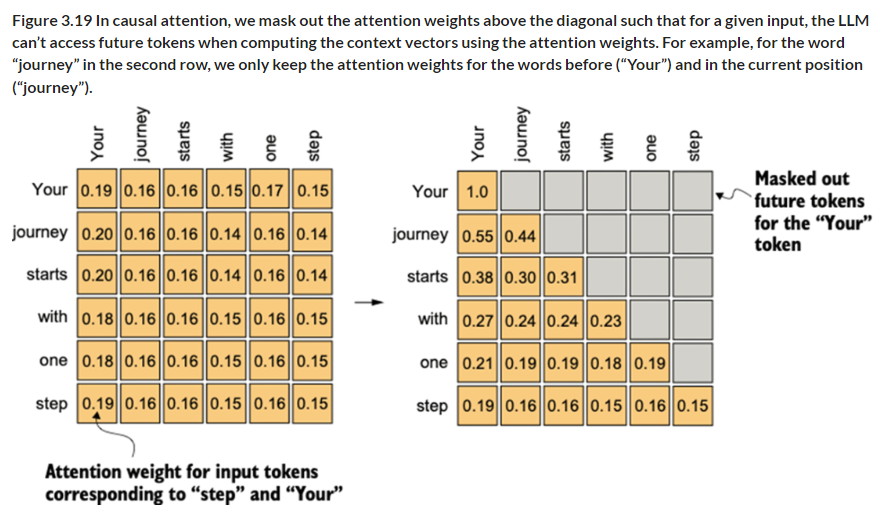

In [20]:
# We normalize the attention weights such that each row sums up to 1.

queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [21]:
# Masking the values above the diagnol to be equal to zero

context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [22]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


In [23]:
#Renormalizing

row_sums = masked_simple.sum(dim=1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


In [ ]:
'''
It might seem there is slight information leakage since we populate the matrix completely before zeroing the upper half.
However, the key insight is that when we renormalize the attention weights after masking,
what we’re essentially doing is recalculating the softmax over a smaller subset (since masked positions don’t contribute to the softmax value).

The mathematical elegance of softmax is that despite initially including all positions in the denominator, after masking and renormalizing,
the effect of the masked positions is nullified—they don’t contribute to the softmax score in any meaningful way.
'''

In [24]:
# A more efficient way to obtain the masked attention weight matrix in causal attention is to mask the attention scores
# with negative infinity values before applying the softmax function.

mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf) #replacing the ones with -inf
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [25]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


### Attention weights -> masking -> simple sum normalization = attention scores -> mask -> softmax

## Masking additional attention weights with dropout

In [ ]:
# We use dropout to prevent overfitting in LLMs.

'''
This method helps prevent overfitting by ensuring that a model does not become overly reliant on any specific set of hidden layer units.
It’s important to emphasize that dropout is only used during training and is disabled afterward.

In the transformer architecture, including models like GPT, dropout in the attention mechanism is typically applied in two specific areas:
after calculating the attention scores or after applying the attention weights to the value vectors.

Here we will apply the dropout mask after computing the attention weights, as illustrated in figure 3.22, because it’s the more common variant in practice.
'''

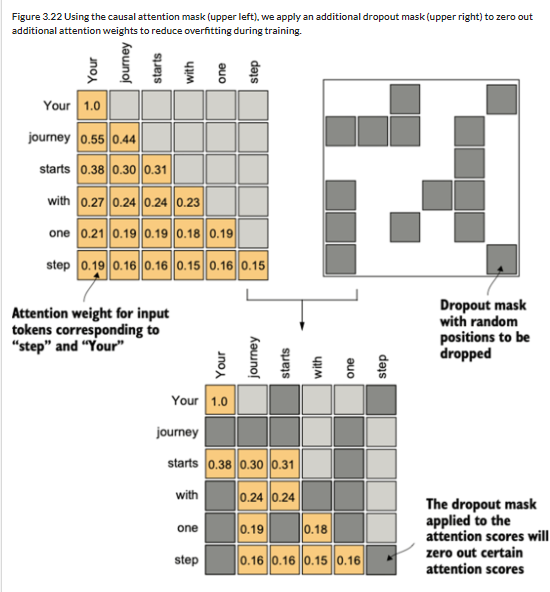

In [26]:
# Implementing dropout

torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) #For gpt like models, this is more like 0.1 or 0.2
example = torch.ones(6, 6)
print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [ ]:
'''
When applying dropout to an attention weight matrix with a rate of 50%, half of the elements in the matrix are randomly set to zero.
To compensate for the reduction in active elements, the values of the remaining elements in the matrix are scaled up by a factor of 1/0.5 = 2.
This scaling is crucial to maintain the overall balance of the attention weights,
ensuring that the average influence of the attention mechanism remains consistent during both the training and inference phases.
'''

In [27]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


In [28]:
# Implementing a compact causal attention class

batch = torch.stack((inputs, inputs), dim=0) #So that the class can handle inputs in batches
print(batch.shape) #This results in a three-dimensional tensor consisting of two input texts with six tokens each, where each token is a three-dimensional embedding vector

torch.Size([2, 6, 3])


In [29]:
# Implementing a compact causal attention class CausalAttention

class CausalAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
    super().__init__()
    self.d_out = d_out
    self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key   = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
    self.dropout = torch.nn.Dropout(dropout)
    self.register_buffer(
        'mask',
        torch.triu(torch.ones(context_length, context_length),
        diagonal=1)
    )

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    queries = self.W_query(x)
    values = self.W_value(x)
    keys = self.W_key(x)

    attn_scores = queries @ keys.transpose(1, 2) # operation changes the shape of the tensor by swapping its second and third dimensions.
    attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)

    context_vec = attn_weights @ values
    return context_vec

In [ ]:
'''
While all added code lines should be familiar from previous sections, we now added a self.register_buffer() call in the __init__ method.
The use of register_buffer in PyTorch is not strictly necessary for all use cases but offers several advantages here.
For instance, when we use the CausalAttention class in our LLM, buffers are automatically moved to the appropriate device (CPU or GPU) along with our model,
which will be relevant when training the LLM in future chapters.
This means we don’t need to manually ensure these tensors are on the same device as your model parameters, avoiding device mismatch errors.
'''

In [30]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


# Extending single-head attention to multi-head attention

In [ ]:
# Extend the previously implemented class over multiple heads

'''
The term “multi-head” refers to dividing the attention mechanism into multiple “heads,” each operating independently.
In this context, a single causal attention module can be considered single-head attention, where there is only one set of attention weights processing the input sequentially.
'''

In [30]:
# First we will implement multi head attention by stacking multiple causal attention modules and then implement the same multi head attention module in a more complicated
# but efficient way

In [ ]:
'''
In practical terms, implementing multi-head attention involves creating multiple instances of the self-attention mechanism,
each with its own weights, and then combining their outputs. Using multiple instances of the self-attention mechanism can be computationally intensive,
but it’s crucial for the kind of complex pattern recognition that models like transformer-based LLMs are known for.
'''

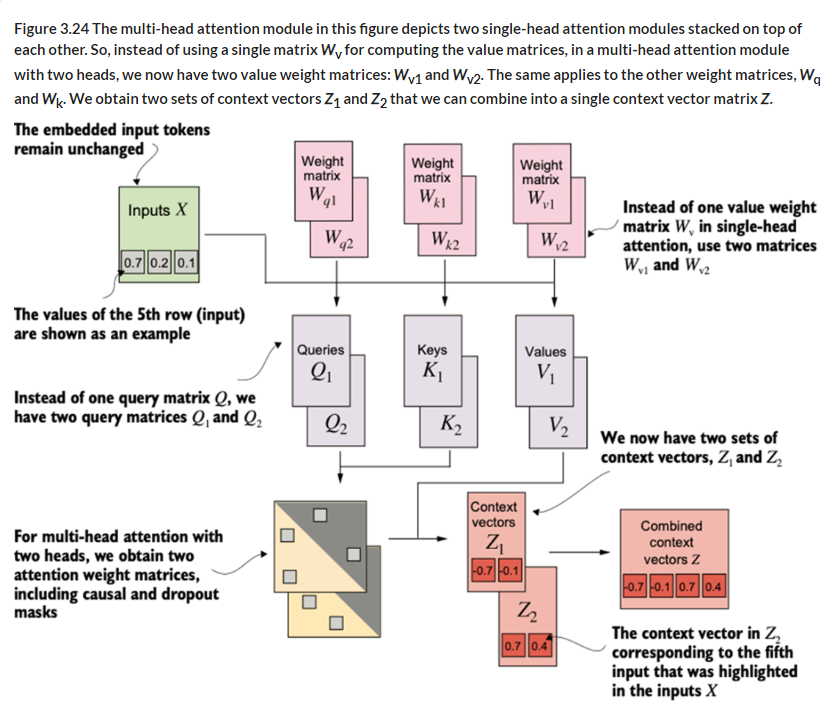

In [31]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length,
                 dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(
                 d_in, d_out, context_length, dropout, qkv_bias
             )
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [42]:
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)
context_vecs = mha(batch)

#Unless seed is specified within the class, the initializations are random

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

'''
The first dimension of the resulting context_vecs tensor is 2 since we have two input texts
(the input texts are duplicated, which is why the context vectors are exactly the same for those).
The second dimension refers to the 6 tokens in each input. The third dimension refers to the four-dimensional embedding of each token.
'''

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


'\nThe first dimension of the resulting context_vecs tensor is 2 since we have two input texts \n(the input texts are duplicated, which is why the context vectors are exactly the same for those). \nThe second dimension refers to the 6 tokens in each input. The third dimension refers to the four-dimensional embedding of each token.\n'

In [ ]:
'''
In this section, we implemented a MultiHeadAttentionWrapper that combined multiple single-head attention modules.
However, note that these are processed sequentially via [head(x) for head in self.heads] in the forward method. We can improve this implementation by processing the heads in parallel.
One way to achieve this is by computing the outputs for all attention heads simultaneously via matrix multiplication, as we will explore in the next section.

In the MultiHeadAttentionWrapper, multiple heads are implemented by creating a list of CausalAttention objects (self.heads), each representing a separate attention head.
The CausalAttention class independently performs the attention mechanism, and the results from each head are concatenated.
In contrast, the following MultiHeadAttention class integrates the multi-head functionality within a single class.
It splits the input into multiple heads by reshaping the projected query, key, and value tensors and then combines the results from these heads after computing attention.
'''

In [44]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out,
                 context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )



    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(
            b, num_tokens, self.num_heads, self.head_dim
        )

        keys = keys.transpose(1, 2) #transposing and switching along dims 1 and 2
        queries = queries.transpose(1, 2) #transposing and switching along dims 1 and 2
        values = values.transpose(1, 2) #transposing and switching along dims 1 and 2

        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )
        context_vec = self.out_proj(context_vec)
        return context_vec

In [ ]:
'''
The key operation is to split the d_out dimension into num_heads and head_dim, where head_dim = d_out / num_heads.
This splitting is then achieved using the .view method: a tensor of dimensions (b, num_tokens, d_out) is reshaped to dimension (b, num_tokens, num_heads, head_dim).
The tensors are then transposed to bring the num_heads dimension before the num_tokens dimension, resulting in a shape of (b, num_heads, num_tokens, head_dim).
This transposition is crucial for correctly aligning the queries, keys, and values across the different heads and performing batched matrix multiplications efficiently.
'''

In [ ]:
'''
In this case, the matrix multiplication implementation in PyTorch handles the four-dimensional input tensor so that
the matrix multiplication is carried out between the two last dimensions (num_tokens, head_dim) and then repeated for the individual heads.

For instance, the preceding becomes a more compact way to compute the matrix multiplication for each head separately:
'''

In [ ]:
'''
The attention weights are used to compute a weighted sum of the values, resulting in the context vectors.
The transpose(1, 2) operation reorders the dimensions back to (b, num_tokens, num_heads, head_dim).

The contiguous().view(b, num_tokens, self.d_out) operation reshapes the context vectors to combine the results from all heads into a single tensor of shape (b, num_tokens, d_out).
'''

In [ ]:
'''
Why Transpose Instead of Stacking Causal Attention Heads?

1. Efficiency: Transposing and reshaping the tensors allows for efficient parallel computation across multiple heads using matrix operations.
This is faster and more efficient than processing each head separately.

2. Scalability: By handling multiple heads in parallel, the model can scale better and take advantage of hardware acceleration (e.g., GPUs).

3. Modularity: Transposing and reshaping operations help in maintaining modular code. Each head processes a different part of the data independently, and the results are then combined in a straightforward manner.
'''

In [ ]:
                  ########################################################################################################
                  ##########                                 End of Chapter 3                                   ##########
                  ########################################################################################################